In [1]:
import numpy as np
import json
import yaml
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from matplotlib.ticker import MaxNLocator

import xobjects as xo
import xtrack as xt
import xpart as xp
import xcoll as xc

import pymadx

from xcoll_plotting import plot_functions as xcp

print('\nxcoll version: ', xc.__version__)
print('xtrack version: ', xt.__version__)
print('xpart version: ', xp.__version__)
print('xobjects version: ', xo.__version__)

context = xo.ContextCpu() 
seed = 1927034333

No pytransport functionality
No pytransport functionality

xcoll version:  0.5.12
xtrack version:  0.72.2
xpart version:  0.19.3
xobjects version:  0.4.6


In [2]:
# ------------ TRACKING FUNCTIONS ----------------

def change_coordinates_to_b1(df):
    if 's' in df.columns:
        df['s'] = end_s - df['s']
    else:
        new_index = [end_s - i for i in df.index.values]
        df.index = new_index 
    return df



def reset_coord_cry_tracking(df, twiss, loc_start, loc_name_start, loc_stop_name = 'ip1', turn = 1):
    names = twiss.to_pandas().name.to_numpy()
    idx_start = np.where(names == loc_name_start)[0][0]
    idx_stop = np.where(names == loc_stop_name)[0][0]
    eps =  1e-11
    df = df.iloc[idx_start:idx_stop]
    names = names[idx_start:idx_stop]
    df = df.copy()
    if turn == 1:
        df['s'] = np.where(df['s'] <= end_s - loc_start + eps, end_s - loc_start - df['s'], 2 * end_s - loc_start - df['s'])
    else:
        df = change_coordinates_to_b1(df)
    df['name'] = names
    df = df.sort_values(by="s")
    return df


def CRY_tw(gap, emittance, element, tw, dim= 'x'):
    mp = 0.9382e9
    emittance_n = 3.5e-6
    gamma = energy/mp
    beta = np.sqrt(1-1/(gamma*gamma))
    emittance = emittance_n/(beta*gamma)

    beta = tw['bet'+dim, element]
    alpha = tw['alf'+dim, element]

    return gap*np.sqrt(emittance*beta), -gap*alpha*np.sqrt(emittance/beta)


def track_particle(part, line, tw, turn = 1, CRY_name = 'tcpch.a5r7.b2'):
    line.scattering.enable() 
    idx_CRY = line.element_names.index(CRY_name)
    if turn > 1:
        line.track(part, ele_start=idx_CRY, ele_stop = idx_CRY, num_turns = turn)
    if part.state > 0:
        start_element =  line.element_names[part.at_element[0]]
        start_loc = line.get_s_position()[part.at_element[0]]
        line.track(part, turn_by_turn_monitor = 'ONE_TURN_EBE', ele_start=idx_CRY)
        df1 = reset_coord_cry_tracking(pd.DataFrame(list(zip(line.record_last_track.s[0], line.record_last_track.x[0], line.record_last_track.y[0], line.record_last_track.py[0])), columns =['s', 'x', 'y', 'py']), 
                                        tw, loc_start = start_loc, loc_name_start = start_element, loc_stop_name = line.element_names[part.at_element[0]-1], turn = turn)
    else:
        df1 = pd.DataFrame(columns =['s', 'x', 'y', 'py'])
    if part.state >0:
        new_start_element =  line.element_names[part.at_element[0]]
        new_start_loc = line.get_s_position()[part.at_element[0]]
        line.track(part, turn_by_turn_monitor = 'ONE_TURN_EBE', ele_stop=idx_CRY)
        df2 = reset_coord_cry_tracking(pd.DataFrame(list(zip(line.record_last_track.s[0],line.record_last_track.x[0], line.record_last_track.y[0], line.record_last_track.py[0])), columns =['s', 'x', 'y', 'py']), 
                                          tw, loc_start = new_start_loc, loc_name_start = new_start_element, loc_stop_name = line.element_names[part.at_element[0]-1], turn = turn)
    else:
        df2 = pd.DataFrame(columns =['s', 'x', 'y', 'py'])
    line.scattering.disable()
    return df1, df2


# ------------ PLOTTING FUNCTIONS ----------------

def fill_between(ax, df_upper, df_lower):
    if df_upper.empty or df_lower.empty:
        return
    if len(df_upper) > len(df_lower):
        idx = len(df_upper) - len(df_lower)
        df1 = df_upper.iloc[idx:]
        df2 = df_lower
    else:
        idx = len(df_lower) - len(df_upper)
        df1 = df_upper
        df2 = df_lower.iloc[idx:]

    ax.fill_between(df1['s'], df1['y'], df2['y'], color='blue', alpha=0.3)

def get_jaw(ax, name, length, tw, end_s, hgap_L, angle = 90, hgap_R = None, plot_skew = False,  color = None, plane = "H"):

    ang_ok = 0 if plane == "H" else 90
    ang_not_ok = 90 if plane == "H" else 0
   
    
    if (plot_skew or angle == ang_ok) and angle != ang_not_ok:
            if color is None:
                color = 'k' if angle == ang_ok else 'grey'
            s_centre = end_s - tw['s', name]
            sstart  = s_centre - length/2
            send    = s_centre + length/2
            w       = send-sstart
            top_lim = plt.ylim()[1]*2
            bot_lim = plt.ylim()[0]*2

            if hgap_L is not None:
                hgap_L_to_set = hgap_L * np.cos(np.deg2rad(angle)) if plane == "H" else hgap_L * np.sin(np.deg2rad(angle))
                h       = top_lim - hgap_L_to_set
                jaw = matplotlib.patches.Rectangle((sstart, hgap_L), w, h, angle=0.0, 
                                                        fc=color, ec=color, zorder=10)
                ax.add_patch(jaw)
            
            if hgap_R is not None:
                hgap_R_to_set = hgap_R * np.cos(np.deg2rad(angle)) if plane == "H" else hgap_R * np.sin(np.deg2rad(angle))
                h = hgap_R_to_set - bot_lim 
                jaw = matplotlib.patches.Rectangle((sstart, bot_lim), w, h, angle=0.0, 
                                                    fc=color, ec=color, zorder=10)
                ax.add_patch(jaw)

def convert_mm_to_m(val):
    return val * 1e-3


In [3]:
# -------------- CONSTANT PARAMETERS -----------------
beam =  2 
plane = 'H' 
emittance_n = 3.5e-6
layout_file = "../input_files/2023_Run3_flat_top/layout_flat_top_b2.tfs"  
layout_data_object = pymadx.Data.Tfs(layout_file)


pymadx.Tfs.Load> normal file


In [4]:
# -------------- SETTABLE PARAMETERS -----------------

coll_file = 'collimators_MD.yaml'
line_file = 'track_injection_b2.json'
sim_dict  = 'MD_dict.json'

energy = 1000 # GeV

CRY_length = 0.004
CRY_bending_radius = 80
CRY_bending_angle = CRY_length/CRY_bending_radius

CRY_name = 'tcpch.a5r7.b2'
TCSG_name = 'tcsg.b4r7.b2'

In [5]:
# ---------------- BUILD LINE ----------------

line = xt.Line.from_json(line_file)

with open(sim_dict, 'r') as f:
    data = json.load(f)

part_energy = data[f'{energy}']['energy'] 
gaps = data[f'{energy}']['gap']

if part_energy is not None:
    line.particle_ref = xt.Particles(p0c=part_energy, #eV
                                q0=1, mass0=xt.PROTON_MASS_EV)
print(f'\nParticle energy: {float(line.particle_ref.p0c)/1e9:} GeV\n')
energy = line.particle_ref.p0c[0]
beta_rel = line.particle_ref.beta0[0]
gamma = line.particle_ref.gamma0[0]
emittance = emittance_n/(beta_rel*gamma)


dp = 1.92e-10 
pot_crit = 21.34
eta = 0.9
Rcrit = energy/(2*np.sqrt(eta)*pot_crit) * (dp/2)
CRY_critical_angle = np.sqrt(2*eta*pot_crit/energy)*(1 - Rcrit/CRY_bending_radius)


end_s = line.get_length()

CRY_loc = line.get_s_position()[line.element_names.index(CRY_name)]
TCSG_loc = line.get_s_position()[line.element_names.index(TCSG_name)]



colldb = xc.CollimatorDatabase.from_yaml(coll_file, beam=beam, ignore_crystals=True)
colldb.install_everest_collimators(line = line,verbose=True)

# Aperture model check
print('\nAperture model check after introducing collimators:')
df_with_coll = line.check_aperture()
assert not np.any(df_with_coll.has_aperture_problem)

df_apertures = xcp.load_apertures(line)
df_apertures = change_coordinates_to_b1(df_apertures)

# Build the tracker
line.build_tracker()
tw = line.twiss()

Loading line from dict:   0%|          | 0/102068 [00:00<?, ?it/s]

Done loading line from dict.           

Particle energy: 999.6599731445312 GeV

Installing tcl.4l5.b2           as EverestCollimator
Installing tcla.d6l7.b2         as EverestCollimator
Installing tcdqa.c4l6.b2        as EverestCollimator
Installing tctph.4r2.b2         as EverestCollimator
Installing tctpv.4r5.b2         as EverestCollimator
Installing tcl.6l1.b2           as EverestCollimator
Installing tclia.4l8            as EverestCollimator
Installing tctpv.4r1.b2         as EverestCollimator
Installing tcsg.d5l7.b2         as EverestCollimator
Installing tcspm.6l7.b2         as EverestCollimator
Installing tdisa.a4r8.b2        as EverestCollimator
Installing tcla.a7l7.b2         as EverestCollimator
Installing tcl.5l1.b2           as EverestCollimator
Installing tcsg.a5l3.b2         as EverestCollimator
Installing tcp.b6r7.b2          as EverestCollimator
Installing tcp.d6r7.b2          as EverestCollimator
Installing tcsg.b5l7.b2         as EverestCollimator
Installing tcsg.5r

Slicing line:   0%|          | 0/102068 [00:00<?, ?it/s]


Aperture model check after introducing collimators:


Checking aperture:   0%|          | 0/102018 [00:00<?, ?it/s]

Done checking aperture.           
0 thin elements miss associated aperture (upstream):
[]
0 thick elements miss associated aperture (upstream or downstream):
[]


In [6]:
# ---------------- SET COLLIMATORS ----------------

line.collimators.assign_optics()

# Set the collimator gaps
for name, gap in gaps.items():
   if gap is not None:
      line[name].gap = gap
      print(f'{name} gap set to: ', line[name].gap)


# Set costum location for the collimators
#line[CRY_name].gap  = 
CRY_gap = line[CRY_name].gap
line[TCSG_name].gap = line[CRY_name].gap

print(f'\nCRY gap set to: {line[CRY_name].gap} ')
print(f'TCSG gap set to: {line[TCSG_name].gap} ')


df_colls = pd.DataFrame(columns=['name', 'angle', 'gap', 'jaw_L', 'jaw_R', 'length'])
for n in colldb.collimator_names:
   if  line[n].__class__.__name__ != 'EverestCrystal':
      df = pd.DataFrame(data = [[n, line[n].angle, line[n].gap, line[n].jaw_L, line[n].jaw_R, line[n].length]], columns=['name', 'angle', 'gap', 'jaw_L', 'jaw_R', 'length'])
      df_colls = pd.concat([df_colls, df], ignore_index=True)

impacts = xc.InteractionRecord.start(line=line)

tcp.6r3.b2 gap set to:  14.484289
tcsp.a4l6.b2 gap set to:  11.405009
tcp.d6r7.b2 gap set to:  6.770734
tcp.c6r7.b2 gap set to:  13.463775
tcspm.b4r7.b2 gap set to:  6.202195
tcsg.b4r7.b2 gap set to:  6.113965
tcpch.a5r7.b2 gap set to:  6.110539165670246

CRY gap set to: 6.110539165670246 
TCSG gap set to: 6.110539 


In [7]:
# ---------------- INITIALIZE PARTICLES ----------------

idx_CRY = line.element_names.index(CRY_name)

CRY_kick = CRY_bending_angle #if ignore_crystals else 0

cry_part_chann = xp.Particles(p0c=energy, #eV
                            q0 = 1, mass0=xp.PROTON_MASS_EV,
                            x = CRY_tw(CRY_gap, emittance, CRY_name, tw)[0],
                            px = CRY_tw(CRY_gap, emittance, CRY_name , tw)[1] + CRY_kick,
                            y = 0,
                            py = 0,
                            at_element = idx_CRY,
                            particle_id = 0,
                            _context=context)

cry_part_chann_upper = xp.Particles(p0c=energy, #eV
                        q0 = 1, mass0=xp.PROTON_MASS_EV,
                        x = CRY_tw(CRY_gap, emittance, CRY_name , tw)[0],
                        px = CRY_tw(CRY_gap, emittance, CRY_name , tw)[1] + CRY_kick + CRY_critical_angle,
                        y = 0,
                        py = 0,
                        at_element = idx_CRY,
                        particle_id = 1,
                        _context=context)


cry_part_chann_lower = xp.Particles(p0c=energy, #eV
                        q0 = 1, mass0=xp.PROTON_MASS_EV,
                        x = CRY_tw(CRY_gap, emittance, CRY_name, tw)[0],
                        px =  CRY_tw(CRY_gap, emittance, CRY_name, tw)[1] + CRY_kick - CRY_critical_angle,
                        y = 0,
                        py = 0,
                        at_element = idx_CRY,
                        particle_id = 2,
                        _context=context)

if seed is not None:
    cry_part_chann._rng_s1, cry_part_chann._rng_s2, cry_part_chann._rng_s3, cry_part_chann._rng_s4 = seed, seed+1, seed+2, seed+3
    cry_part_chann_upper._rng_s1, cry_part_chann_upper._rng_s2, cry_part_chann_upper._rng_s3, cry_part_chann_upper._rng_s4 = seed, seed+1, seed+2, seed+3
    cry_part_chann_lower._rng_s1, cry_part_chann_lower._rng_s2, cry_part_chann_lower._rng_s3, cry_part_chann_lower._rng_s4 = seed, seed+1, seed+2, seed+3

In [8]:
# ---------------- TRACKING ----------------

turn_to_track = 1

df_chann_L, df_chann_R = track_particle(cry_part_chann, line, tw, turn_to_track)
df_chann_upper_L, df_chann_upper_R = track_particle(cry_part_chann_upper, line, tw,turn_to_track)
df_chann_lower_L, df_chann_lower_R = track_particle(cry_part_chann_lower, line, tw, turn_to_track)

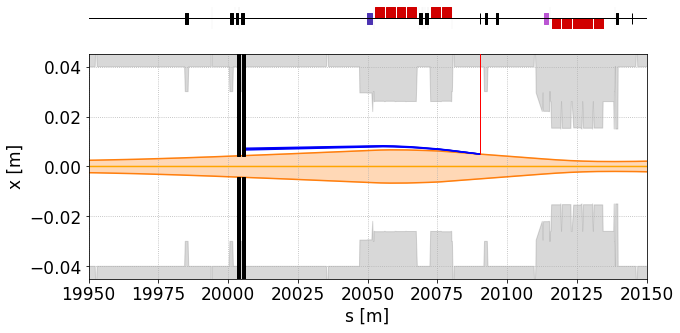

In [ ]:
# ---------------- PLOT ----------------

start, stop = 19950, 20150 #19000, 21000 # #0, end_s
n_env = CRY_gap
plot_cry_envelope = True 
figsize = (10, 5) #(25,6)
plot_skew = False

dim = 'x' if plane == 'H' else 'y'


fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [0.1, 1]}, sharex=True, figsize=figsize)
pymadx.Plot._SetMachineAxesStyle(ax[0])
pymadx.Plot._DrawMachineLattice(ax[0], layout_data_object)
ax[0].set_xlim(start,stop)
#ir3_plot[0].set_title(label='Energy = 1 TeV', y=1.05, fontsize=18)


df_ref = change_coordinates_to_b1(tw.to_pandas())
ax[1].plot(df_ref["s"],df_ref[dim],color="orange")
ax[1].plot(df_ref["s"], n_env*np.sqrt(emittance*df_ref['bet'+dim]) + df_ref[dim], color='C1')
ax[1].plot(df_ref["s"],-n_env*np.sqrt(emittance*df_ref['bet'+dim])+ df_ref[dim], color='C1')
ax[1].fill_between(df_ref["s"], n_env*np.sqrt(emittance*df_ref['bet'+dim]) + df_ref[dim], -n_env*np.sqrt(emittance*df_ref['bet'+dim])+ df_ref[dim], color='C1', alpha=0.3)

ax[1].plot(df_chann_L["s"],df_chann_L[dim], color='darkblue')
ax[1].plot(df_chann_R["s"],df_chann_R[dim], color='darkblue')

if plot_cry_envelope:
    ax[1].plot(df_chann_upper_L["s"],df_chann_upper_L[dim], color='blue')
    ax[1].plot(df_chann_upper_R["s"],df_chann_upper_R[dim], color='blue')
    ax[1].plot(df_chann_lower_L["s"],df_chann_lower_L[dim], color='blue')
    ax[1].plot(df_chann_lower_R["s"],df_chann_lower_R[dim], color='blue')
    fill_between(ax[1], df_chann_upper_R, df_chann_lower_R)
    fill_between(ax[1], df_chann_upper_L, df_chann_lower_L)

ax[1].set_xlabel('s [m]',  fontsize=17)
ax[1].set_xlim(start, stop)
ax[1].set_ylim(-0.045, 0.045)
ax[1].set_ylabel(dim+' [m]',  fontsize=17)
ax[1].grid(linestyle=':')
ax[1].tick_params(axis='both', which='major', labelsize=17)
xcp.plot_apertures(df_apertures[['xmin', 'xmax', 'ymin', 'ymax']].apply(lambda x: convert_mm_to_m(x)), ax[1], "h")
   
get_jaw(ax[1],CRY_name, CRY_length, tw, end_s, hgap_L= CRY_tw(CRY_gap, emittance, CRY_name, tw)[0], angle = 0,  color = 'r')
for n in df_colls.name:
    coll = df_colls[df_colls['name'] == n]
    get_jaw(ax[1],n, coll.length.values[0], tw, end_s, angle = coll.angle.values[0],  hgap_L = coll.jaw_L.values[0], hgap_R = coll.jaw_R.values[0], plot_skew = plot_skew)



In [10]:
print("Particle absorbed at: ",  line.element_names[cry_part_chann.at_element[0]])

Particle absorbed at:  tcsg.b4r7.b2
